In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.ndimage

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import peak_local_max

from scipy.optimize import curve_fit
from scipy.special import gamma

In [2]:
matplotlib.use('pdf')
#plt.rcParams['figure.dpi'] = 400
#plt.style.use('fivethirtyeight')

In [14]:
def find_smoothest_max(signal, coords):

    if (len(coords) == 0):
        return np.array([signal.shape[0] // 2, signal.shape[1] // 2])

    mean_signal = np.zeros(len(coords))
    
    for i, coordinate in enumerate(coords):

        amplitude = signal[coordinate[0], coordinate[1]]

        neighbours = neighbors(signal, coordinate[1], coordinate[0])

        mean_signal[i] = (np.sum(neighbours) + amplitude) / (len(neighbours) + 1)

    smoothest_max_coord = coords[np.argmax(mean_signal)]

    return smoothest_max_coord

def neighbors(matrix, rowNumber, colNumber):
    result = []
    for rowAdd in range(-1, 2):
        newRow = rowNumber + rowAdd
        if newRow >= 0 and newRow <= len(matrix)-1:
            for colAdd in range(-1, 2):
                newCol = colNumber + colAdd
                if newCol >= 0 and newCol <= len(matrix)-1:
                    if newCol == colNumber and newRow == rowNumber:
                        continue
                    result.append(matrix[newCol][newRow])
    return np.array(result)

In [22]:
carpet_signal_data = pd.read_csv('Data_2023-2024_410_CarpetMeas.csv', sep=';', header = None, usecols=list(range(20, 420)))
carpet_angle_data = pd.read_csv('Data_2023-2024_410_CarpetMeas.csv', sep=';', header = None, usecols=list(range(10, 12)))
carpet_Ne_data =  pd.read_csv('Data_2023-2024_410_CarpetMeas.csv', sep=';', header = None, usecols=[16])

In [24]:
carpet_signals = carpet_signal_data.to_numpy()
carpet_angles = carpet_angle_data.to_numpy()
carpet_Nes = carpet_Ne_data.to_numpy()

In [ ]:
pdf = PdfPages("1000_Real_Showers_reconsctruction_total_upscale.pdf")

upscale_factors = np.array([1, 2, 3, 5, 10, 50])

for i in range(1000):

    sig = carpet_signals[i].reshape((20, 20))

    nRows = 2
    nColumns = 3

    fig, axs = plt.subplots(nRows, nColumns)

    for upscale_number, upscale_factor in enumerate(upscale_factors):

        k = (upscale_number) // nColumns
        j = upscale_number % nColumns
        
        upsc_sig = np.round(scipy.ndimage.zoom(sig, upscale_factor, order=3), 3)
    
        #peak_region = upsc_sig[xy[0]*upscale_factor:(xy[0]+1)*upscale_factor, xy[1]*upscale_factor:(xy[1]+1)*upscale_factor]
    
        axs[k, j].imshow(upsc_sig, cmap='turbo')
        axs[k, j].grid(False)
        
        axs[k, j].set_xticks(ticks=[])
        axs[k, j].set_yticks(ticks=[])
        
        coordinates_new = peak_local_max(upsc_sig, exclude_border=False, threshold_rel=0.1)
        xy_new = find_smoothest_max(upsc_sig, coordinates_new)
        
        #axs[1].axvline(x=xy[1]*upscale_factor + xy_new[1], linewidth=1, color='r')
        #axs[1].axhline(y=xy[0]*upscale_factor + xy_new[0], linewidth=1, color='r')
    
        axs[k, j].axvline(x = xy_new[1], linewidth=2, color='r')
        axs[k, j].axhline(y = xy_new[0], linewidth=2, color='r')

        if (k == 0) and (j == 0):
            axs[k, j].set_title('Оригинал')
        else:
            axs[k, j].set_title('Масштабирование ' + str(upscale_factor))

    fig.tight_layout()
    pdf.savefig()
    plt.close('all')

pdf.close()

In [ ]:
pdf = PdfPages("Big_Difference_Showers.pdf")

for signal in carpet_signals:
#for i in range(100):

    sig = signal.reshape((20, 20))

    coordinates = peak_local_max(sig, exclude_border=False, threshold_rel=0.1)
    xy = find_smoothest_max(sig, coordinates)

    upscale_factor = 2

    upsc_sig = scipy.ndimage.zoom(sig, upscale_factor, order=3)

    coordinates_new = peak_local_max(upsc_sig, exclude_border=False, threshold_rel=0.1)
    xy_new = find_smoothest_max(upsc_sig, coordinates_new)

    diff = 70/upscale_factor*np.sqrt(((xy[1])*upscale_factor + 0.5 - xy_new[1])**2 + ((xy[0])*upscale_factor + 0.5 - xy_new[0])**2)

    if diff > 100:

        fig, axs = plt.subplots(1, 2)
        
        axs[0].imshow(sig, cmap='turbo')
        axs[0].grid(False)
        
        axs[0].set_xticks(ticks=[])
        axs[0].set_yticks(ticks=[])
        
        axs[0].axvline(x=xy[1], linewidth=2, color='r')
        axs[0].axhline(y=xy[0], linewidth=2, color='r')
    
        #peak_region = upsc_sig[xy[0]*upscale_factor:(xy[0]+1)*upscale_factor, xy[1]*upscale_factor:(xy[1]+1)*upscale_factor]
    
        axs[1].imshow(upsc_sig, cmap='turbo')
        axs[1].grid(False)
        
        axs[1].set_xticks(ticks=[])
        axs[1].set_yticks(ticks=[])
        
        #axs[1].axvline(x=xy[1]*upscale_factor + xy_new[1], linewidth=1, color='r')
        #axs[1].axhline(y=xy[0]*upscale_factor + xy_new[0], linewidth=1, color='r')
    
        axs[1].axvline(x = xy_new[1], linewidth=2, color='r')
        axs[1].axhline(y = xy_new[0], linewidth=2, color='r')
    
        fig.tight_layout()
        pdf.savefig()
        plt.close('all')

pdf.close()

# Idea

In [6]:
def VEM(hist):

    rel_p = 8*1.12**(hist - 1)
    rel_p[rel_p < 8] = 0

    return rel_p

In [29]:
x_cover = np.round(np.arange(-6.65, 6.66, 0.7), 2)
y_cover = np.round(np.arange(-6.65, 6.66, 0.7), 2)

def fit_coeffs(row_ind, row_centres, row_weights, col_ind, col_centres, col_weights):

    row_polyfit = np.polynomial.Polynomial.fit(row_ind, row_centres, deg=1, w=row_weights).convert().coef
    col_polyfit = np.polynomial.Polynomial.fit(col_ind, col_centres, deg=1, w=col_weights).convert().coef

    b_row = row_polyfit[0]
    k_row = row_polyfit[-1]

    b_col = col_polyfit[0]
    k_col = col_polyfit[-1]

    row_errors = (row_centres - k_row*row_ind - b_row)**2
    col_errors = (col_centres - k_col*col_ind - b_col)**2

    if np.any(row_errors > 5**2):
        
        worst_point = np.argmax(row_errors)
        
        row_ind = np.delete(row_ind, worst_point)
        row_centres = np.delete(row_centres, worst_point)
        row_weights = np.delete(row_weights, worst_point)

        row_polyfit = np.polynomial.Polynomial.fit(row_ind, row_centres, 1, w=row_weights).convert().coef

        b_row = row_polyfit[0]
        k_row = row_polyfit[-1]

    if np.any(col_errors > 5**2):
        
        worst_point = np.argmax(col_errors)
        
        col_ind = np.delete(col_ind, worst_point)
        col_centres = np.delete(col_centres, worst_point)
        col_weights = np.delete(col_weights, worst_point)

        col_polyfit = np.polynomial.Polynomial.fit(col_ind, col_centres, 1, w=col_weights).convert().coef

        b_col = col_polyfit[0]
        k_col = col_polyfit[-1]

    return np.array([[b_row, k_row], [b_col, k_col]])

def get_xy_fits(hist):

    non_zero_cols = np.count_nonzero(np.count_nonzero(hist, axis=0))
    non_zero_rows = np.count_nonzero(np.count_nonzero(hist, axis=1))
    
    if ((non_zero_cols >= 2) and (non_zero_rows >= 2)):
    
        n_rows = hist.shape[0]
        n_cols = hist.shape[1]
    
        row_ind = np.arange(0, n_rows)
        col_ind = np.arange(0, n_cols)
    
        row_weights = np.zeros(n_rows)
        row_centres = np.zeros(n_rows)
        
        col_weights = np.zeros(n_cols)
        col_centres = np.zeros(n_cols)
    
        for i in range(n_rows):
            row = hist[i]
            
            weight = np.sum(row)

            maxima = np.argwhere(row == row.max())
            centre = np.mean(maxima)
            
            row_weights[i] = weight
            row_centres[i] = centre
        for i in range(n_cols):
    
            col = hist[:, i]
            
            weight = np.sum(col)
            
            maxima = np.argwhere(col == col.max())
            centre = np.mean(maxima)
            
            col_weights[i] = weight
            col_centres[i] = centre
    
        coeffs = fit_coeffs(row_ind, row_centres, row_weights, col_ind, col_centres, col_weights)

        b_row = coeffs[0, 0]
        k_row = coeffs[0, 1]

        b_col = coeffs[1, 0]
        k_col = coeffs[1, 1]

        if (k_col*k_row == 1):
            col0 = np.mean(col_ind[np.nonzero(col_weights)])
            row0 = k_col*col0 + b_col
        else:
            col0 = (k_row*b_col + b_row) / (1-k_row*k_col)
            row0 = k_col*col0 + b_col
        
        return [row0, col0]
    
    else:
        
        return [9.5, 9.5]

def get_xy(signal):

    i, j = get_xy_fits(signal)

    x = 0.7*j - 6.65
    y = 6.65 - 0.7*i

    return [x, y]

def get_rho(i):

    signal = VEM(carpet_signals[i].reshape((20, 20)))

    x0, y0 = get_xy(signal)

    theta, phi = np.radians(carpet_angles[i])

    rho = []
    r = [] 

    for i in range(len(y_cover)):
        for j in range(len(x_cover)):

            x = x_cover[j]
            y = y_cover[19 - i]
            
            r_ij = np.sqrt(((x-x0)*np.sin(theta)*np.sin(phi) - (y-y0)*np.cos(theta)*np.cos(phi))**2 + ((x-x0)*np.cos(theta))**2 + ((y-y0)*np.cos(theta))**2)
            
            k_ij = 1 + 7.503 / (1.636 + r_ij**1.474)
            rho_ij= signal[i, j] / (0.49 * k_ij)

            if (r_ij > 0) and (rho_ij > 0):

                rho.append(rho_ij)
                r.append(r_ij)

    r = np.array(r)
    rho = np.array(rho)
    ind  = np.argsort(r)

    return [r[ind], rho[ind]]

def NKG(x, s, Ne):
    return (Ne / 95**2) * (gamma(4.5 - s)/(2*np.pi*gamma(s)*gamma(4.5 - 2*s))) * (x / 95)**(s - 2) * (1 + (x/95))**(s - 4.5)

In [9]:
pdf = PdfPages("test.pdf")

for i in range(1000):

    signal = carpet_signals[i].reshape((20, 20))

    sig = VEM(signal)
    
    non_zero_cols = np.count_nonzero(np.count_nonzero(sig, axis=0))
    non_zero_rows = np.count_nonzero(np.count_nonzero(sig, axis=1))

    if ((non_zero_cols >= 2) and (non_zero_rows >= 2)):

        plt.imshow(signal, cmap='turbo')
    
        row0, col0 = get_xy_fits(sig)

        for j in range(sig.shape[0]):
            for k in range(sig.shape[1]):
                    text = plt.text(k, j, int(sig[j, k]), ha="center", va="center", color="w", fontsize=3)

        plt.plot(col0, row0, 'mo')
    
        pdf.savefig()
        plt.close('all')

pdf.close()

In [46]:
Ne_rec = []
Ne_cov = []

for i in range(carpet_Nes.shape[0]):
    
    r, rho = get_rho(i)

    try:
        popt, pcov = curve_fit(NKG, r, rho, method='dogbox')
        Ne_rec.append(popt[1])
        Ne_cov.append(carpet_Nes[i])
    except RuntimeError:
        ...
    except TypeError:
        ...
    except ValueError:
        ...

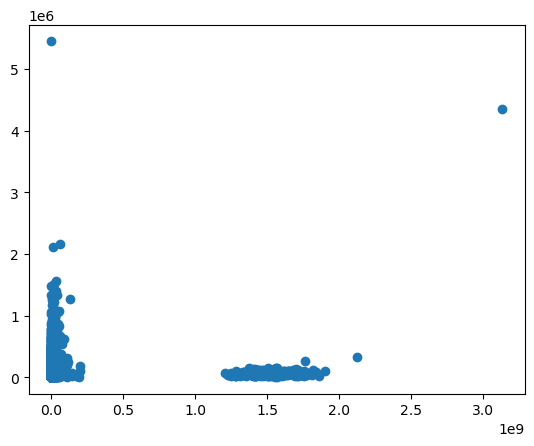

In [47]:
plt.scatter(Ne_rec, Ne_cov)